In [1]:
from matplotlib import pyplot as plt, style, ticker
from datetime import datetime
from lxml import html, etree
from urllib.parse import quote_plus, urlparse, parse_qs
from time import sleep
import pandas as pd
import requests

style.use('ggplot')

In [2]:
# getting html tree from the url
url = "http://www.nasdaq.com/symbol/{stock}/institutional-holdings?page={page}"
stock = "AAPL"
page = requests.get(
    url.format(stock=quote_plus(stock.lower()), page=1)
)
tree = html.fromstring(page.content)
print(tree)
print([e for e in tree])

<Element html at 0x7f4d641c3e08>
[<Element head at 0x7f4d641c3f48>, <Element body at 0x7f4d641c3ae8>]


<h4>Let's get the number of pages from the last link in the footer</h4>
<img src="2_footer.png">

In [3]:
pager = tree.find('.//ul[@id="pager"]')
page_links = pager.findall('.//a')
href = page_links[-1].attrib['href']
href

'https://www.nasdaq.com/symbol/aapl/institutional-holdings?page=188'

In [4]:
parsed_url = urlparse(href)
query_params = parse_qs(parsed_url.query)
max_page = int(query_params['page'][0])
max_page

188

<h4>Now we are ready to get all the data</h4>
<img src="2_table.png">

In [5]:
df = pd.DataFrame([], columns=('Name', 'Date', 'Held', 'Change', 'ChangePercent', 'Value')) # empty
i = 0
for page_num in range(1, max_page + 1):
    table, attempts = None, 0
    while table is None:
        page = requests.get(
            url.format(stock=quote_plus(stock.lower()), page=page_num)
        )
        tree = html.fromstring(page.content)
        blocks = tree.findall('.//div[@id="quotes_content_left_pnlInsider"]')  
        
        try:
            table = blocks[0].getchildren()[0] 
        except IndexError:
            attempts += 1
            sleep_time = 3 ** attempts
            sleep(sleep_time)
            print("Blocked, sleep for {}sec".format(sleep_time))
    
    for row in table:
        if row.tag == 'tr':
            df.loc[i] = [col.text_content() for col in row]
            i += 1
df

Blocked, sleep for 3sec
Blocked, sleep for 3sec
Blocked, sleep for 3sec


,Name,Date,Held,Change,ChangePercent,Value
0,VANGUARD GROUP INC,12/31/2017,"348,468,032","3,879,342",1.13,"62,069,126"
1,BLACKROCK INC.,12/31/2017,"319,715,585","5,112,055",1.63,"56,947,740"
2,STATE STREET CORP,12/31/2017,"208,739,070","2,291,579",1.11,"37,180,603"
3,BERKSHIRE HATHAWAY INC,12/31/2017,"165,333,962","31,241,180",23.30,"29,449,285"
4,FMR LLC,12/31/2017,"121,724,426","(23,765,684)",(16.34),"21,681,555"
5,PRICE T ROWE ASSOCIATES INC /MD/,12/31/2017,"72,476,069","973,363",1.36,"12,909,437"
6,NORTHERN TRUST CORP,12/31/2017,"65,684,289","(1,962,144)",(2.9),"11,699,686"
7,"GEODE CAPITAL MANAGEMENT, LLC",12/31/2017,"56,447,158","1,356,879",2.46,"10,054,368"
8,BANK OF NEW YORK MELLON CORP,12/31/2017,"53,301,694","360,312",.68,"9,494,098"
9,JPMORGAN CHASE & CO,12/31/2017,"51,621,255","(1,140,335)",(2.16),"9,194,778"


In [6]:
# everything as a singe function + type conversions of values
def get_institutional_holdings(stock):
    url = "http://www.nasdaq.com/symbol/{stock}/institutional-holdings?page={page}"
    page = requests.get(
        url.format(stock=quote_plus(stock.lower()), page=1)
    )
    tree = html.fromstring(page.content)
    # get pager
    pager = tree.find('.//ul[@id="pager"]')
    page_links = pager.findall('.//a')
    href = page_links[-1].attrib['href']

    # get the max page number from the last link
    parsed_url = urlparse(href)
    query_params = parse_qs(parsed_url.query)
    max_page = int(query_params['page'][0])

    # pull data from every page
    df = pd.DataFrame([], columns=('Name', 'Date', 'Held', 'Change', 'ChangePercent', 'Value'))
    
    def to_int(val):
        return int(val.strip('()').replace(',', '')) if val else 0

    i = 0
    for page_num in range(1, max_page + 1):

        page = requests.get(
            url.format(stock=quote_plus(stock.lower()), page=page_num)
        )
        tree = html.fromstring(page.content)

        blocks = tree.findall('.//div[@id="quotes_content_left_pnlInsider"]')
        table = blocks[0].getchildren()[0]
        
        for row in table:
            if row.tag == 'tr':
                raw_values = [col.text_content().strip() for col in row]
                name = raw_values[0]
                date = datetime.strptime(raw_values[1], "%m/%d/%Y").date()
                held = to_int(raw_values[2])
                decreased = raw_values[3].startswith('(')
                change = to_int(raw_values[3]) * (-1) ** decreased
                percent = raw_values[4]
                value = to_int(raw_values[5])

                df.loc[i] = (name, date, held, change, percent, value)
                i += 1
    return df
            
df = get_institutional_holdings('X')
df

,Name,Date,Held,Change,ChangePercent,Value
0,VANGUARD GROUP INC,2017-12-31,15079047.0,-24486.0,(0.16),656089.0
1,BLACKROCK INC.,2017-12-31,14848328.0,116386.0,.79,646051.0
2,AMERIGO ASSET MANAGEMENT,2017-12-31,6969995.0,790799.0,12.80,303264.0
3,STATE STREET CORP,2017-12-31,5780799.0,-192686.0,(3.23),251523.0
4,"D. E. SHAW & CO., INC.",2017-12-31,4451543.0,2579446.0,137.78,193687.0
5,JPMORGAN CHASE & CO,2017-12-31,4273833.0,3638111.0,572.28,185954.0
6,DIMENSIONAL FUND ADVISORS LP,2017-12-31,4118963.0,960350.0,30.40,179216.0
7,"GALLAGHER FIDUCIARY ADVISORS, LLC",2017-12-31,3763643.0,0.0,0.00,163756.0
8,SLATE PATH CAPITAL LP,2017-12-31,3280000.0,1050000.0,47.09,142713.0
9,GOLDMAN SACHS GROUP INC,2017-12-31,2947162.0,887374.0,43.08,128231.0


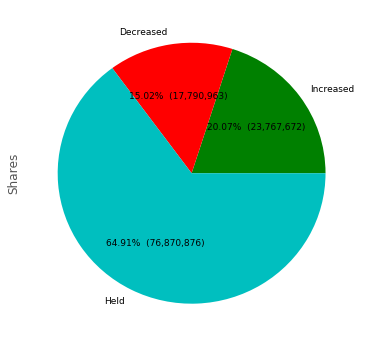

,Count,Shares
Increased,213.0,23767674.0
Decreased,167.0,17790963.0
Held,62.0,76870878.0


In [7]:
# prepare dataframe
active_df = pd.DataFrame([], columns=('Count', 'Shares'))

inc_holders = df[df.Change > 0]
active_df.loc['Increased'] = len(inc_holders), inc_holders.Change.sum()

decr_holders = df[df.Change < 0]
active_df.loc['Decreased'] = len(decr_holders), abs(decr_holders.Change.sum())

held_holders = df[df.Change == 0]
active_df.loc['Held'] = len(held_holders), df.Held.sum() - active_df['Shares'].sum()

# it's just to show values and percents on the chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:,})'.format(p=pct,v=val)
    return my_autopct

# plot dataframe
active_df.Shares.plot.pie(figsize=(6, 6), colors=['g', 'r', 'c'], 
                          autopct=make_autopct(active_df.Shares), fontsize=9)
plt.show()

active_df

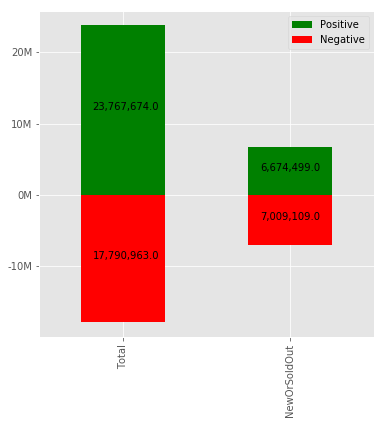

,Positive,Negative
Total,23767674.0,-17790963.0
NewOrSoldOut,6674499.0,-7009109.0


In [8]:
# prepare dataframe for plotting
new_sold_df = pd.DataFrame([], columns=('Positive', 'Negative'))

new_sold_df.loc['Total'] = active_df.loc['Increased']['Shares'], active_df.loc['Decreased']['Shares'] * (-1)

new = df[df.ChangePercent == 'New']
sold = df[df.ChangePercent == 'Sold Out']
new_sold_df.loc['NewOrSoldOut'] = new.Change.sum(), sold.Change.sum()

# plot data
ax = new_sold_df.plot.bar(figsize=(6, 6), color=['g', 'r'], stacked=True)

# format axis, show values
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%dM" % (x / 1000000)))
for i, label in enumerate(list(new_sold_df.index)):
    pos_score = new_sold_df.ix[label]['Positive']
    ax.annotate('{:,}'.format(pos_score), (i - .18, pos_score * .5))
    neg_score = new_sold_df.ix[label]['Negative']
    ax.annotate('{:,}'.format(abs(neg_score)), (i - .18, neg_score * .5))
    
plt.show()

new_sold_df

### From the feedback


In [9]:
df.groupby(['Date']).sum()  # grouping by date

,Held,Change,Value
Date,,,
2017-03-31,41153.0,40075.0,1791.0
2017-06-30,69152.0,19704.0,3009.0
2017-09-30,79794.0,-64949.0,3472.0
2017-12-31,118239416.0,5981881.0,5144588.0


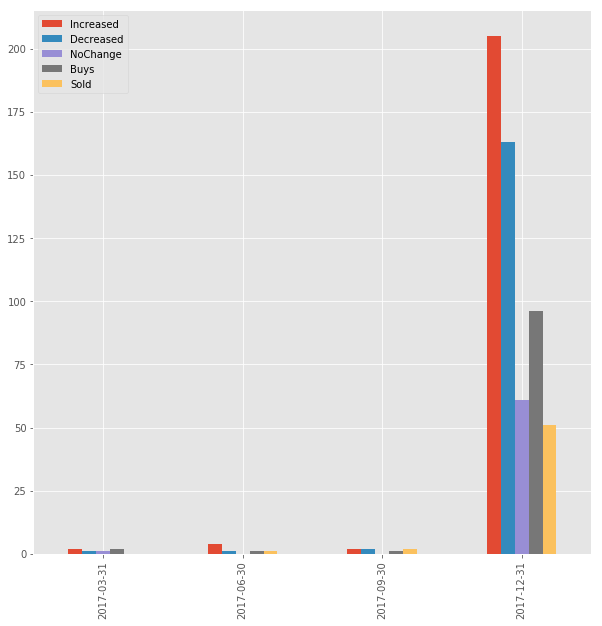

,Increased,Decreased,NoChange,Buys,Sold
2017-03-31,2,1,1.0,2,NaN
2017-06-30,4,1,NaN,1,1.0
2017-09-30,2,2,NaN,1,2.0
2017-12-31,205,163,61.0,96,51.0


In [10]:
df_trend = pd.DataFrame(index=df.Date.unique())

df_trend['Increased'] = df[df.Change > 0].groupby(['Date'])['Change'].count()
df_trend['Decreased'] = df[df.Change < 0].groupby(['Date'])['Change'].count()
df_trend['NoChange'] = df[df.Change == 0].groupby(['Date'])['Change'].count()
df_trend['Buys'] = df[df.ChangePercent == "New"].groupby(['Date'])['Change'].count()
df_trend['Sold'] = df[df.ChangePercent == "Sold Out"].groupby(['Date'])['Change'].count()

df_trend.sort_index(inplace=True)

df_trend.plot.bar(figsize=(10, 10))
plt.show()
df_trend

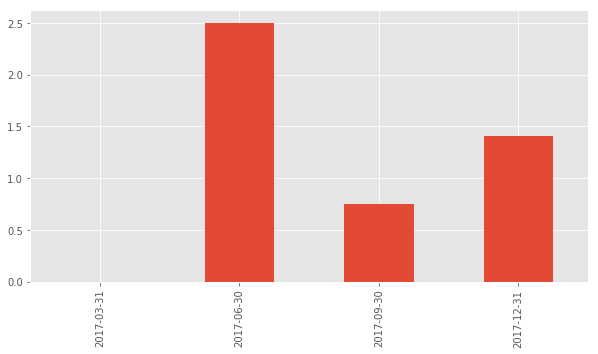

,Increased,Decreased,NoChange,Buys,Sold,BullishRank
2017-03-31,2,1,1.0,2,NaN,NaN
2017-06-30,4,1,NaN,1,1.0,2.500000
2017-09-30,2,2,NaN,1,2.0,0.750000
2017-12-31,205,163,61.0,96,51.0,1.406542


In [11]:
df_trend['BullishRank'] = (df_trend.Increased + df_trend.Buys) / (df_trend.Decreased + df_trend.Sold)
df_trend['BullishRank'].plot.bar(figsize=(10, 5))
plt.show()
df_trend

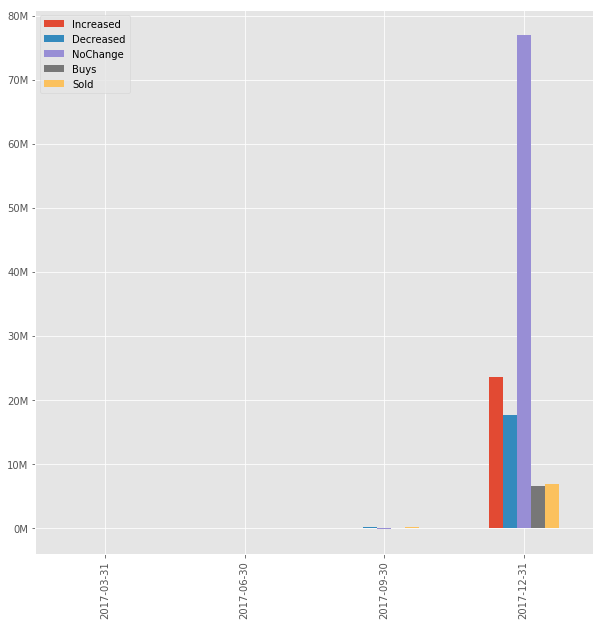

,Increased,Decreased,NoChange,Buys,Sold
2017-03-31,40617.0,542.0,-6.0,40617.0,NaN
2017-06-30,31208.0,11504.0,26440.0,10000.0,11504.0
2017-09-30,76151.0,141100.0,-137457.0,33859.0,141100.0
2017-12-31,23619698.0,17637817.0,76981901.0,6590023.0,6856505.0


In [12]:
df_sum_trend = pd.DataFrame(index=df.Date.unique())


df_sum_trend['Increased'] = df[df.Change > 0].groupby(['Date'])['Change'].sum()
df_sum_trend['Decreased'] = df[df.Change < 0].groupby(['Date'])['Change'].sum() * (-1)
df_sum_trend['NoChange'] = df.groupby(['Date'])['Held'].sum() - df_sum_trend.Decreased - df_sum_trend.Increased
df_sum_trend['Buys'] = df[df.ChangePercent == "New"].groupby(['Date'])['Change'].sum()
df_sum_trend['Sold'] = df[df.ChangePercent == "Sold Out"].groupby(['Date'])['Change'].sum() * (-1)

df_sum_trend.sort_index(inplace=True)

ax = df_sum_trend.plot.bar(figsize=(10, 10))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%dM" % (x / 1000000)))
plt.show()
df_sum_trend

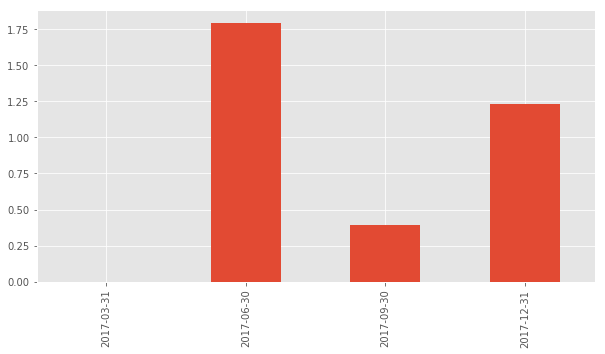

,Increased,Decreased,NoChange,Buys,Sold,BullishRank
2017-03-31,40617.0,542.0,-6.0,40617.0,NaN,NaN
2017-06-30,31208.0,11504.0,26440.0,10000.0,11504.0,1.791029
2017-09-30,76151.0,141100.0,-137457.0,33859.0,141100.0,0.389830
2017-12-31,23619698.0,17637817.0,76981901.0,6590023.0,6856505.0,1.233336


In [13]:
df_sum_trend['BullishRank'] = (df_sum_trend.Increased + df_sum_trend.Buys) / (df_sum_trend.Decreased + df_sum_trend.Sold)
df_sum_trend['BullishRank'].plot.bar(figsize=(10, 5))
plt.show()
df_sum_trend